In [1]:
# Support developing the code on a small cpu only system
# The small numbers allow the code to be quickly checked for functionality.
use_tiny_sizes_for_dev = False
if use_tiny_sizes_for_dev:
    report_count = 1
    batch_size = 2
    training_size = 10
    validation_size = 10
    test_size = 10
    epochs = 2
    generator_steps_per_epoch = 1
    generator_epochs = 2
    generator_validation_steps = 1
else:
    report_count = 100
    batch_size = 20
    training_size = 2000
    validation_size = 1000
    test_size = 1000
    epochs = 20
    generator_steps_per_epoch = 100
    generator_epochs = 30
    generator_validation_steps = 50


In [2]:
import keras

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [3]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

In [4]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [5]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

# base_dir = '/home/bstell_ml001/Downloads/cats_and_dogs_small'
base_dir = '/home/ubuntu/Downloads/cats_and_dogs_small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# print('total train images:', 
#       len(os.listdir(os.path.join(train_dir, 'cats'))) +
#       len(os.listdir(os.path.join(train_dir, 'dogs'))))

datagen = ImageDataGenerator(rescale=1./255)


In [7]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        if i % report_count == 0:
            print('i:', i)
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, training_size)
validation_features, validation_labels = extract_features(validation_dir, validation_size)
test_features, test_labels = extract_features(test_dir, test_size)

Found 2000 images belonging to 2 classes.
i: 0
Found 1000 images belonging to 2 classes.
i: 0
Found 1000 images belonging to 2 classes.
i: 0


In [8]:
train_features = np.reshape(train_features, (training_size, 4 * 4* 512))
validation_features = np.reshape(validation_features, (validation_size, 4 * 4* 512))
test_features = np.reshape(test_features, (test_size, 4 * 4* 512))

In [9]:
from keras import models, layers, optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                   validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/20
2000/2000 [==============================] - 1s 527us/step - loss: 0.5947 - acc: 0.6750 - val_loss: 0.4372 - val_acc: 0.8270
Epoch 2/20
2000/2000 [==============================] - 1s 344us/step - loss: 0.4223 - acc: 0.8105 - val_loss: 0.3586 - val_acc: 0.8670
Epoch 3/20
2000/2000 [==============================] - 1s 347us/step - loss: 0.3546 - acc: 0.8470 - val_loss: 0.3313 - val_acc: 0.8550
Epoch 4/20
2000/2000 [==============================] - 1s 345us/step - loss: 0.3137 - acc: 0.8750 - val_loss: 0.2979 - val_acc: 0.8950
Epoch 5/20
2000/2000 [==============================] - 1s 352us/step - loss: 0.2884 - acc: 0.8850 - val_loss: 0.2848 - val_acc: 0.8940
Epoch 6/20
2000/2000 [==============================] - 1s 347us/step - loss: 0.2763 - acc: 0.8855 - val_loss: 0.2718 - val_acc: 0.9030
Epoch 7/20
2000/2000 [==============================] - 1s 343us/step - loss: 0.2481 - acc: 0.8990 - val_loss: 0.2677 - val_acc: 0.9000


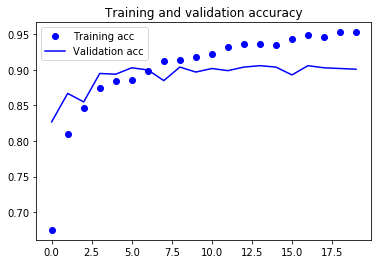

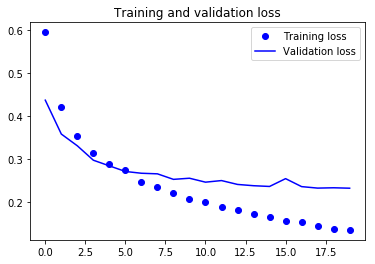

In [11]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [12]:
from keras import models, layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [15]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [16]:
conv_base.trainable = False

In [17]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


In [18]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=generator_steps_per_epoch,
    epochs=generator_epochs,
    validation_data=validation_generator,
    validation_steps=generator_validation_steps,
    verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
 - 28s - loss: 0.6012 - acc: 0.6790 - val_loss: 0.4517 - val_acc: 0.8270
Epoch 2/30
 - 26s - loss: 0.4879 - acc: 0.7880 - val_loss: 0.3791 - val_acc: 0.8530
Epoch 3/30
 - 26s - loss: 0.4444 - acc: 0.8075 - val_loss: 0.3306 - val_acc: 0.8690
Epoch 4/30
 - 26s - loss: 0.4122 - acc: 0.8205 - val_loss: 0.3072 - val_acc: 0.8840
Epoch 5/30
 - 26s - loss: 0.3803 - acc: 0.8340 - val_loss: 0.2899 - val_acc: 0.8890
Epoch 6/30
 - 26s - loss: 0.3618 - acc: 0.8395 - val_loss: 0.2796 - val_acc: 0.8920
Epoch 7/30
 - 26s - loss: 0.3710 - acc: 0.8310 - val_loss: 0.2761 - val_acc: 0.8870
Epoch 8/30
 - 26s - loss: 0.3507 - acc: 0.8510 - val_loss: 0.2645 - val_acc: 0.8930
Epoch 9/30
 - 26s - loss: 0.3350 - acc: 0.8575 - val_loss: 0.2599 - val_acc: 0.8960
Epoch 10/30
 - 26s - loss: 0.3379 - acc: 0.8530 - val_loss: 0.2587 - val_acc: 0.8950
Epoch 11/30
 - 26s - loss: 0.3294 - acc: 0.8650 - val_loss: 0.2566 - val_ac

In [19]:
model.save('cats_and_dogs_small_3.h5')

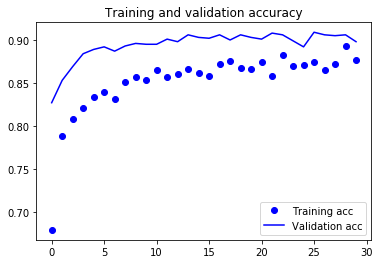

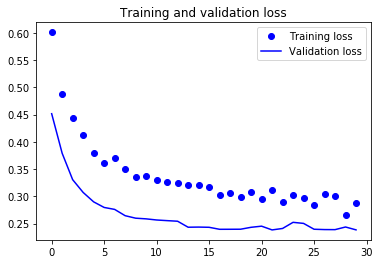

In [20]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()